In [20]:
import networkx as nx
from networkx.algorithms import approximation, community
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from matplotlib.lines import Line2D


matplotlib.rc('xtick', labelsize=13)     
matplotlib.rc('ytick', labelsize=13)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"

# Define the recursive classical divide and conquer algorithm

In [2]:
MAX_RECURSION_DEPTH = 10

def classical_MIS_approach(G, chosen_vertices=None, progress=None, verbose=0):
    chosen_vertices = chosen_vertices or set()
    progress = progress or [0]
    
    leftover_vertices = set(G)
    for i in chosen_vertices:
        leftover_vertices -= {i}
        leftover_vertices -= set(G.neighbors(i))
    # now, leftover_vertices contains the vertices in G that could still be added to the MIS
    
    if len(leftover_vertices) <= 1:
        chosen_vertices |= leftover_vertices
        assert_is_independent_set(G, chosen_vertices)
        progress.append(len(chosen_vertices))
        final_progress = progress[-1]
        progress = progress + [final_progress] * (MAX_RECURSION_DEPTH - len(progress))
        return progress
    
    if len(progress) > MAX_RECURSION_DEPTH:
        chosen_vertices |= approximation.maximum_independent_set(nx.subgraph(G, leftover_vertices))
        assert_is_independent_set(G, chosen_vertices)
        progress.append(len(chosen_vertices))
        return progress

    leftover_graph = nx.subgraph(G, leftover_vertices)
    setA, setB = community.kernighan_lin_bisection(leftover_graph)
    assert len(setA & setB) == 0 and (setA | setB) == leftover_vertices
    
    cutsetA = set(filter(lambda i: any([j in setB for j in leftover_graph.neighbors(i)]), setA))
    cutsetB = set(filter(lambda i: any([j in setA for j in leftover_graph.neighbors(i)]), setB))
    
    cutedges = [edge for edge in leftover_graph.edges() if (edge[0] in setA and edge[1] in setB)
                                                        or (edge[0] in setB and edge[1] in setA)]

    if verbose:
        print('Cut {} edges'.format(len(cutedges)))
    
    subgraphA = nx.subgraph(leftover_graph, (setA - cutsetA))
    subgraphB = nx.subgraph(leftover_graph, (setB - cutsetB))
    
    misA = approximation.maximum_independent_set(subgraphA)
    misB = approximation.maximum_independent_set(subgraphB)
    assert len(misA & misB) == 0
    
    assert len((misA | misB) & chosen_vertices) == 0
    chosen_vertices |= (misA | misB)
    progress.append(len(chosen_vertices))
    
    return classical_MIS_approach(G, chosen_vertices, progress)


def assert_is_independent_set(G, chosen_vertices):
    for i in chosen_vertices:
        for j in G.neighbors(i):
            assert j not in chosen_vertices

## Testing

In [4]:
classical_MIS_approach(nx.erdos_renyi_graph(100, 0.1))

[0, 2, 4, 7, 15, 21, 22, 22, 22, 22]

Average BH is 23.7
Average with our classical approach is 26.6


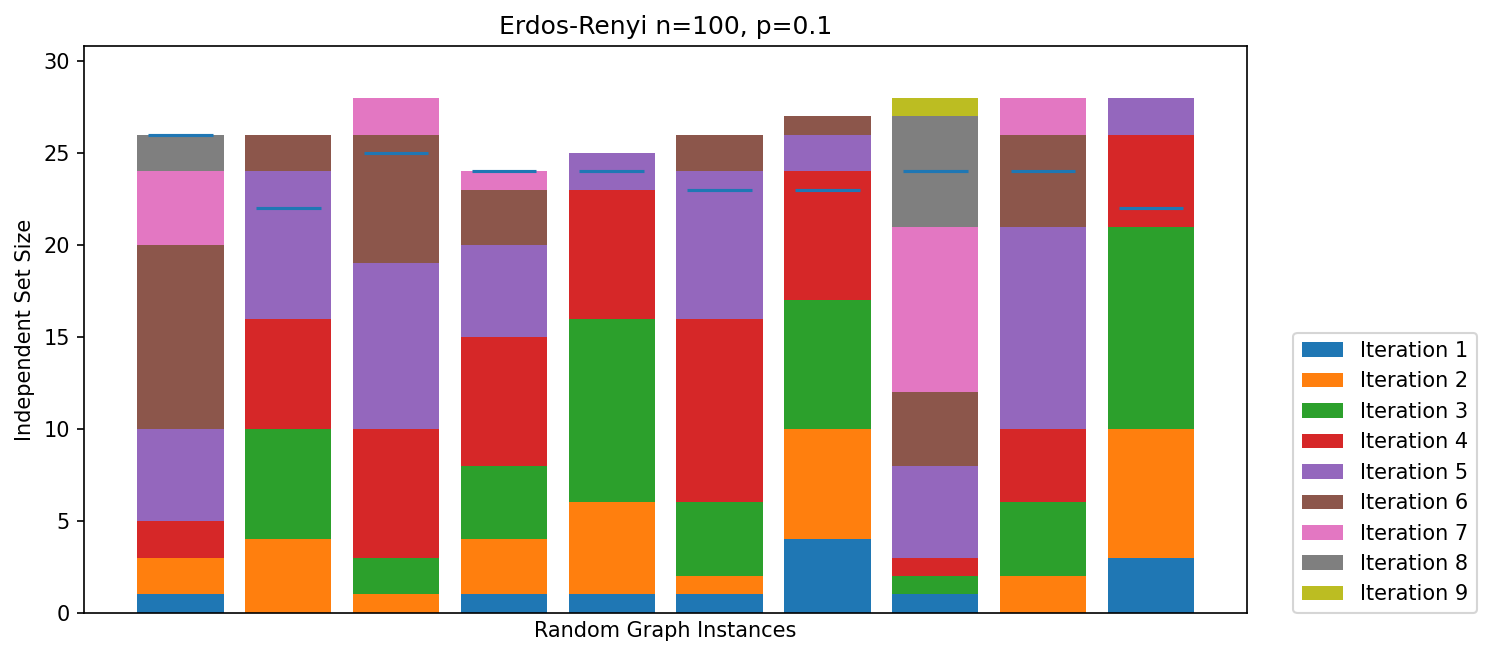

In [20]:
bh_list, progress_list = [], []
NUM_GRAPHS = 10
n = 100
p = 0.1

for _ in range(NUM_GRAPHS):
    G = nx.erdos_renyi_graph(n, p)
    bh_list.append(len(approximation.maximum_independent_set(G)))
    progress_list.append(classical_MIS_approach(G))
    
    
plt.figure(dpi=150, figsize=(10, 5))
plt.title(f"Erdos-Renyi n={n}, p={p}"); plt.xlabel("Random Graph Instances"); plt.ylabel("Independent Set Size")
plt.ylim(
    0,
    max([max([max(progress) for progress in progress_list]), max(bh_list)]) * 1.1
)
plt.xticks([])

    
for j in range(1, MAX_RECURSION_DEPTH):
    plt.bar(
        range(NUM_GRAPHS),
        [progress[j] - progress[j - 1] for progress in progress_list],
        bottom=[progress[j - 1] for progress in progress_list],
        label=f"Iteration {j}",
    )
    
for i in range(NUM_GRAPHS):
    plt.hlines(bh_list[i], xmin=i-0.3, xmax=i+0.3)
    
plt.legend(loc=(1.04,0));

print("Average BH is", np.mean(bh_list))
print("Average with our classical approach is", np.mean([progress[-1] for progress in progress_list]))

# Classical performance on 100-node graphs

## Performance over iterations of the CDC algorithm

In [3]:
NUM_GRAPHS = 50
reps = 5
n = 100
MAX_REPS = 10

print('START erdos-renyi graphs\n')
er_bh_list, er_progress_list = [], []
p = 0.1
for i in range(NUM_GRAPHS):
    print(f'{i}, ', end='')
    G = nx.erdos_renyi_graph(n, p)
    while not nx.is_connected(G):
        G = nx.erdos_renyi_graph(n, p)
    temp_bh_list, temp_progress_list = [], []
    for _ in range(reps):
        temp_bh_list.append(len(approximation.maximum_independent_set(G)))
        pl = classical_MIS_approach(G, verbose=0)
        if len(pl) > 10:
            pl = pl[:10]
        temp_progress_list.append(pl)
    
    er_bh_list.append(max(temp_bh_list))
    er_progress_list.append(sorted(temp_progress_list, key=lambda p: p[-1])[-1])
print()

print('\nSTART d-regular graphs\n')
dr_bh_list, dr_progress_list = [], []
d = 3
for i in range(NUM_GRAPHS):
    print(f'{i}, ', end='')
    G = nx.generators.random_graphs.random_regular_graph(d, n)
    temp_bh_list, temp_progress_list = [], []
    for _ in range(reps):
        temp_bh_list.append(len(approximation.maximum_independent_set(G)))
        pl = classical_MIS_approach(G, verbose=0)
        if len(pl) > 10:
            pl = pl[:10]
        temp_progress_list.append(pl)    
        
    dr_bh_list.append(max(temp_bh_list))
    dr_progress_list.append(sorted(temp_progress_list, key=lambda p: p[-1])[-1])
print()
    
print("(Erdos-Renyi) Average BH is", np.mean(er_bh_list))
print("(Erdos-Renyi) Average with our classical approach is", np.mean([progress[-1] for progress in er_progress_list]))
print("(d-regular) Average BH is", np.mean(dr_bh_list))
print("(d-regular) Average with our classical approach is", np.mean([progress[-1] for progress in dr_progress_list]))

START erdos-renyi graphs

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 

START d-regular graphs

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 
(Erdos-Renyi) Average BH is 24.2
(Erdos-Renyi) Average with our classical approach is 27.82
(d-regular) Average BH is 38.36
(d-regular) Average with our classical approach is 39.34


In [49]:
print('\nSTART (0.2, 0.02)-community graphs\n')
pp_bh_list, pp_progress_list = [], []
num_communities = 5
community_size = 20
p_in = 0.2
p_out = 0.02
for i in range(NUM_GRAPHS):
    print(f'{i}, ', end='')
    G = nx.generators.planted_partition_graph(l=num_communities, k=community_size, p_in=p_in, p_out=p_out)
    while not nx.is_connected(G):
        G = nx.generators.planted_partition_graph(l=num_communities, k=community_size, p_in=p_in, p_out=p_out)
    temp_bh_list, temp_progress_list = [], []
    for _ in range(reps):
        temp_bh_list.append(len(approximation.maximum_independent_set(G)))
        pl = classical_MIS_approach(G, verbose=0)
        if len(pl) > 10:
            pl = pl[:10]
        temp_progress_list.append(pl)    
        
    pp_bh_list.append(max(temp_bh_list))
    pp_progress_list.append(sorted(temp_progress_list, key=lambda p: p[-1])[-1])
print()
print("(community) Average BH is", np.mean(pp_bh_list))
print("(community) Average with our classical approach is", np.mean([progress[-1] for progress in pp_progress_list]))


START (0.2, 0.02)-community graphs

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 
(community) Average BH is 34.38
(community) Average with our classical approach is 37.52


In [50]:
print('\nSTART (0.2, 0.02)-community graphs\n')
pp_bh_list2, pp_progress_list2 = [], []
num_communities = 2
community_size = 50
p_in = 0.2
p_out = 0.02
for i in range(NUM_GRAPHS):
    print(f'{i}, ', end='')
    G = nx.generators.planted_partition_graph(l=num_communities, k=community_size, p_in=p_in, p_out=p_out)
    while not nx.is_connected(G):
        G = nx.generators.planted_partition_graph(l=num_communities, k=community_size, p_in=p_in, p_out=p_out)
    temp_bh_list, temp_progress_list = [], []
    for _ in range(reps):
        temp_bh_list.append(len(approximation.maximum_independent_set(G)))
        pl = classical_MIS_approach(G, verbose=0)
        if len(pl) > 10:
            pl = pl[:10]
        temp_progress_list.append(pl)    
        
    pp_bh_list2.append(max(temp_bh_list))
    pp_progress_list2.append(sorted(temp_progress_list, key=lambda p: p[-1])[-1])
print()
print("(community) Average BH is", np.mean(pp_bh_list2))
print("(community) Average with our classical approach is", np.mean([progress[-1] for progress in pp_progress_list2]))


START (0.2, 0.02)-community graphs

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 
(community) Average BH is 22.74
(community) Average with our classical approach is 25.38


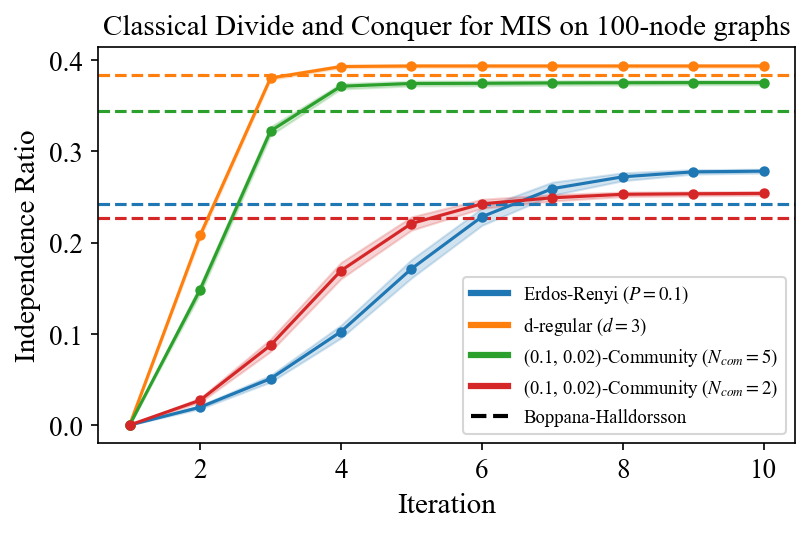

In [51]:
fig, ax = plt.subplots(dpi=150, figsize=[6,3.5])

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
labels = ['Erdos-Renyi ($P=0.1$)', 'd-regular ($d=3$)',
          '(0.1, 0.02)-Community ($N_{com}=5$)', '(0.1, 0.02)-Community ($N_{com}=2$)']
bh_results = [er_bh_list, dr_bh_list, pp_bh_list, pp_bh_list2]
for i, results in enumerate([er_progress_list, dr_progress_list, pp_progress_list, pp_progress_list2]):    
    means   = np.mean(results, axis=0) / 100
    stderrs = np.std(results, axis=0) / np.sqrt(len(results)) / 100
    
    x = np.arange(1, len(means)+1)
    ax.errorbar(x, means, label=labels[i], fmt='-o', ms=4, color=colors[i])

    y1 = [m+s for m, s in zip(means, stderrs)]
    y2 = [max(m-s, 0) for m, s in zip(means, stderrs)]
    ax.fill_between(x, y1, y2, alpha=0.2, color=colors[i])
    
    ax.axhline(y=np.mean(bh_results[i]) / 100, ls='--', c=colors[i])

#ax.axhline(y=1, ls='--', c='k')
#ax.set_xlim([0.5,max(iterations)+0.5])
#ax.set_xticks(np.arange(1,max(iterations),2))
ax.set_xlabel('Iteration', fontsize=14)
ax.set_ylabel('Independence Ratio', fontsize=14)
ax.set_title('Classical Divide and Conquer for MIS on 100-node graphs', fontsize=14)

custom_lines = [Line2D([0], [0], color='tab:blue', lw=3),
                Line2D([0], [0], color='tab:orange', lw=3),
                Line2D([0], [0], color='tab:green', lw=3),
                Line2D([0], [0], color='tab:red', lw=3),
                Line2D([0], [0], color='k', ls='--', lw=2)]
ax.legend(custom_lines, labels+['Boppana-Halldorsson'], fontsize=9)
#plt.savefig('figures/MICRO/classical_divide_and_conquer.pdf', bbox_inches="tight")

## Performance over number of nodes

In [12]:
er_approx_ratios, dr_approx_ratios = [], []
NUM_GRAPHS = 100
n_range = np.arange(20, 210, 10)
p = 0.1
d = 3

for n in n_range:
    print('-'*30,'\nSTART {}-node graphs'.format(n), '\n' + '-'*30)

    print('\tSTART erdos-renyi graphs')
    temp_approx_ratios = []
    for _ in range(NUM_GRAPHS):
        G = nx.erdos_renyi_graph(n, p)
        bh_mis = len(approximation.maximum_independent_set(G))
        dc_mis = classical_MIS_approach(G)[-1]
        temp_approx_ratios.append(dc_mis / bh_mis)
    er_approx_ratios.append((n, np.mean(temp_approx_ratios), np.std(temp_approx_ratios)))

    print('\tSTART d-regular graphs')
    temp_approx_ratios = []
    for _ in range(NUM_GRAPHS):
        G = nx.generators.random_graphs.random_regular_graph(d, n)
        bh_mis = len(approximation.maximum_independent_set(G))
        dc_mis = classical_MIS_approach(G)[-1]
        temp_approx_ratios.append(dc_mis / bh_mis)
    dr_approx_ratios.append((n, np.mean(temp_approx_ratios), np.std(temp_approx_ratios)))

------------------------------ 
START 20-node graphs 
------------------------------
	START erdos-renyi graphs
	START d-regular graphs
------------------------------ 
START 30-node graphs 
------------------------------
	START erdos-renyi graphs
	START d-regular graphs
------------------------------ 
START 40-node graphs 
------------------------------
	START erdos-renyi graphs
	START d-regular graphs
------------------------------ 
START 50-node graphs 
------------------------------
	START erdos-renyi graphs
	START d-regular graphs
------------------------------ 
START 60-node graphs 
------------------------------
	START erdos-renyi graphs
	START d-regular graphs
------------------------------ 
START 70-node graphs 
------------------------------
	START erdos-renyi graphs
	START d-regular graphs
------------------------------ 
START 80-node graphs 
------------------------------
	START erdos-renyi graphs
	START d-regular graphs
------------------------------ 
START 90-node graphs 
-

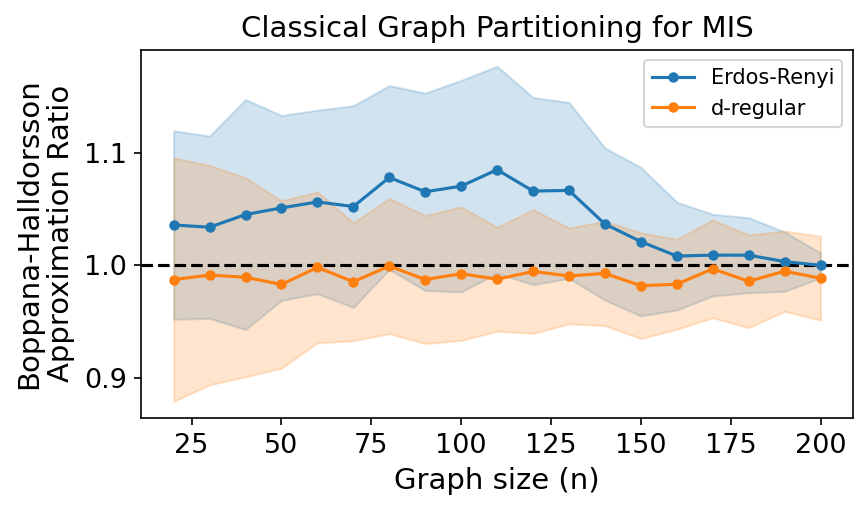

In [15]:
fig, ax = plt.subplots(dpi=150, figsize=[6,3.5])

data = [er_approx_ratios, dr_approx_ratios]
color = ['tab:blue', 'tab:orange']
label = ['Erdos-Renyi', 'd-regular']
for i, dat in enumerate(data):
    x = [d[0] for d in dat]
    means = [d[1] for d in dat]
    stddevs = [d[2] for d in dat]
    
    ax.errorbar(x, means, label=label[i], fmt='-o', ms=4, color=color[i])

    y1 = [m+s for m, s in zip(means, stddevs)]
    y2 = [m-s for m, s in zip(means, stddevs)]
    ax.fill_between(x, y1, y2, alpha=0.2, color=color[i])


ax.axhline(y=1, ls='--', c='k')
#ax.set_xlim([0.5,max(iterations)+0.5])
#ax.set_xticks(np.arange(1,max(iterations),2))
ax.set_xlabel('Graph size (n)', fontsize=14)
ax.set_ylabel('Boppana-Halldorsson\nApproximation Ratio', fontsize=14)
ax.set_title('Classical Graph Partitioning for MIS', fontsize=14)

#custom_lines = [Line2D([0], [0], color='tab:blue', lw=4, alpha=0.5),
#                Line2D([0], [0], color='tab:orange', lw=4, alpha=0.5)]
ax.legend()
plt.tight_layout()
plt.savefig('figures/classical_scaling.pdf')

# Graph density

In [19]:
er_degrees = []
for n in n_range:
    temp_degree = []
    for _ in range(NUM_GRAPHS):
        G = nx.erdos_renyi_graph(n, p)
        degs = [d[1] for d in G.degree]
        temp_degree.append(np.mean(degs))
    er_degrees.append((n, np.mean(temp_degree), np.std(temp_degree)))
    
dr_degrees = []
for n in n_range:
    temp_degree = []
    for _ in range(NUM_GRAPHS):
        G = nx.generators.random_graphs.random_regular_graph(d, n)
        degs = [d[1] for d in G.degree]
        temp_degree.append(np.mean(degs))
    dr_degrees.append((n, np.mean(temp_degree), np.std(temp_degree)))

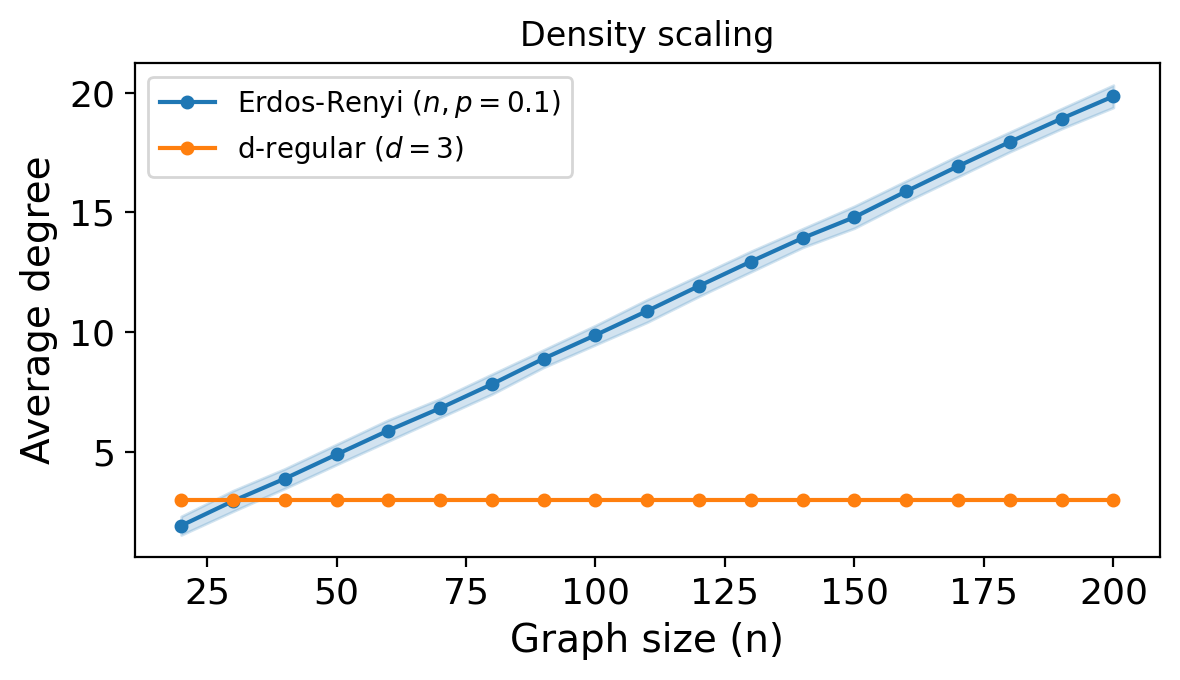

In [25]:
fig, ax = plt.subplots(dpi=200, figsize=[6,3.5])



data = [er_degrees, dr_degrees]
color = ['tab:blue', 'tab:orange']
label = [r'Erdos-Renyi $(n, p=0.1)$', r'd-regular $(d=3)$']
for i, dat in enumerate(data):
    x = [d[0] for d in dat]
    y = [d[1] for d in dat]
    std = [d[2] for d in dat]
    
    ax.errorbar(x, y, label=label[i], fmt='-o', ms=4, color=color[i])

    y1 = [m+s for m, s in zip(y, std)]
    y2 = [m-s for m, s in zip(y, std)]
    ax.fill_between(x, y1, y2, alpha=0.2, color=color[i])

ax.set_ylabel('Average degree', fontsize=14)
ax.set_xlabel('Graph size (n)', fontsize=14)
ax.set_title('Density scaling')
ax.legend()
plt.tight_layout()
plt.savefig('figures/density_scaling.pdf')

# Number of edges cut during bisection

Consider 3-regular, (P=0.1)-Erdos-Renyi, and (0.1, 0.02)-Community graphs with varying numbers of communities.
For graphs ranging in size from 20, 60, 100 nodes, partition 1000 instances of each graph type, record the 
- total number of edges in the graph
- number of cut edges
- relative sizes of the subgraphs (smaller subgraph / larger subgraph)

The information can be summarized with a table

In [48]:
for i, graph_type in enumerate(['3-regular', '(P=0.1)-Erdos-Renyi',
                                '(0.2, 0.02)-Community (N_c = 2)',
                                '(0.2, 0.02)-Community (N_c = 5)']):
    print(graph_type)
    for graph_size in [20, 60, 100]:
        total_edges, cut_edges, relative_sizes = [], [], []
        count = 1
        while count <= 1000:
            # Generate a connected graph
            if i == 0:
                G = nx.generators.random_graphs.random_regular_graph(3, graph_size)
            elif i == 1:
                G = nx.erdos_renyi_graph(graph_size, 0.1)
                while not nx.is_connected(G):
                    G = nx.erdos_renyi_graph(graph_size, 0.1)
            elif i == 2:
                G = nx.generators.planted_partition_graph(l=2, k=int(graph_size/2), p_in=0.1, p_out=0.02)
                while not nx.is_connected(G):
                    G = nx.generators.planted_partition_graph(l=2, k=int(graph_size/2), p_in=0.1, p_out=0.02)
            elif i == 3:
                G = nx.generators.planted_partition_graph(l=5, k=int(graph_size/5), p_in=0.1, p_out=0.02)
                while not nx.is_connected(G):
                    G = nx.generators.planted_partition_graph(l=5, k=int(graph_size/5), p_in=0.1, p_out=0.02)
            
            total_edges.append(len(G.edges))
            # Partition graph
            setA, setB = community.kernighan_lin_bisection(G)
            
            if len(setA) >= len(setB):
                relative_sizes.append(len(setB) / len(setA))
            else:
                relative_sizes.append(len(setA) / len(setB))
            
            cutsetA = set(filter(lambda i: any([j in setB for j in G.neighbors(i)]), setA))
            cutsetB = set(filter(lambda i: any([j in setA for j in G.neighbors(i)]), setB))

            cutedges = [edge for edge in G.edges() if (edge[0] in setA and edge[1] in setB)
                                                       or (edge[0] in setB and edge[1] in setA)]
            cut_edges.append(len(cutedges))
            
            count += 1
        
        # Average results
        print(f'\tAveraged over 1000 random {graph_size}-node graphs: {np.mean(total_edges):.2f} total edges per graph,\n'
              f'\twith {np.mean(cut_edges):.2f} cut edges in the bisection,\n'
              f'\tand {np.mean(relative_sizes):.2f} ratio between the subgraphs\n')

3-regular
	Averaged over 1000 random 20-node graphs: 30.00 total edges per graph,
	with 6.48 cut edges in the bisection,
	and 1.00 ratio between the subgraphs

	Averaged over 1000 random 60-node graphs: 90.00 total edges per graph,
	with 16.51 cut edges in the bisection,
	and 1.00 ratio between the subgraphs

	Averaged over 1000 random 100-node graphs: 150.00 total edges per graph,
	with 36.48 cut edges in the bisection,
	and 1.00 ratio between the subgraphs

(P=0.1)-Erdos-Renyi
	Averaged over 1000 random 20-node graphs: 25.23 total edges per graph,
	with 4.70 cut edges in the bisection,
	and 1.00 ratio between the subgraphs

	Averaged over 1000 random 60-node graphs: 178.42 total edges per graph,
	with 50.58 cut edges in the bisection,
	and 1.00 ratio between the subgraphs

	Averaged over 1000 random 100-node graphs: 494.92 total edges per graph,
	with 176.18 cut edges in the bisection,
	and 1.00 ratio between the subgraphs

(0.1, 0.02)-Community (N_c = 2)
	Averaged over 1000 random 2

KeyboardInterrupt: 

# More tests

Average BH is 62.1
Average with our classical approach is 60.8


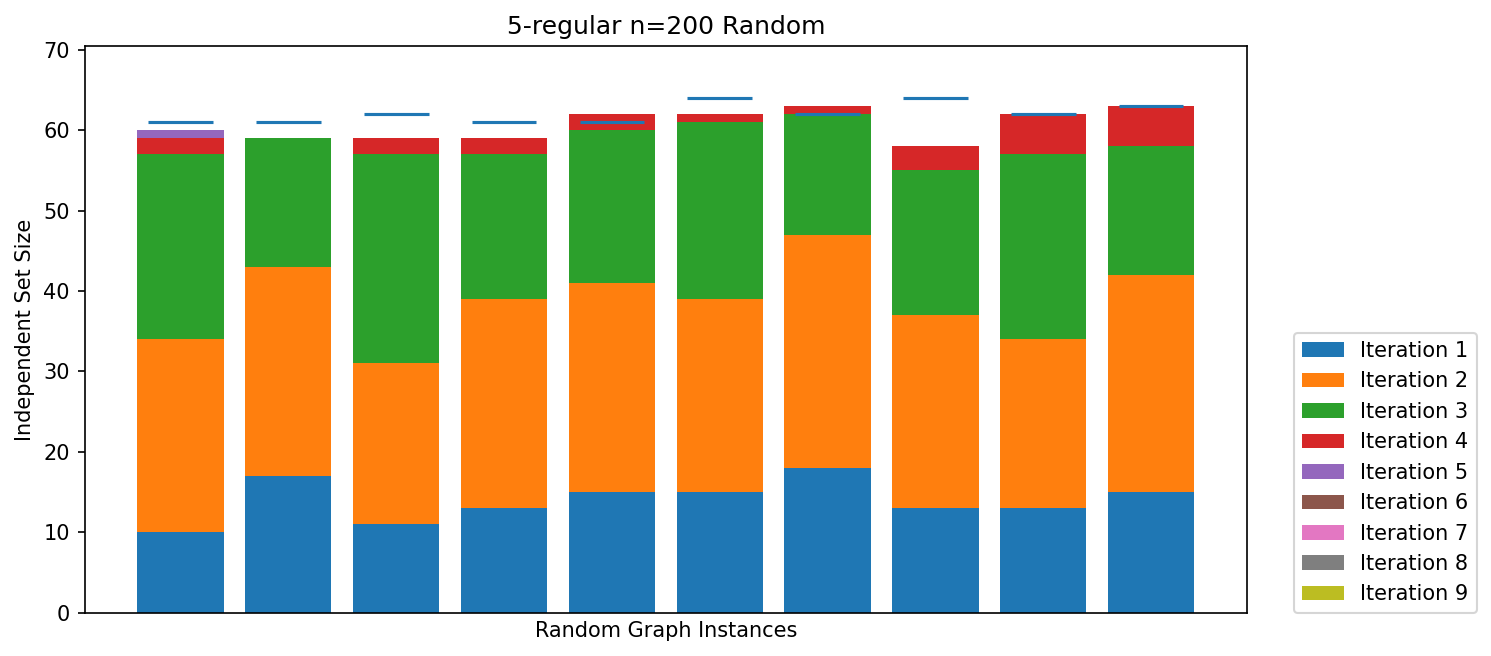

In [22]:
bh_list, progress_list = [], []
NUM_GRAPHS = 10
n = 200
d = 5

for _ in range(NUM_GRAPHS):
    G = nx.random_regular_graph(d, n)
    bh_list.append(len(approximation.maximum_independent_set(G)))
    progress_list.append(classical_MIS_approach(G))
    
    
plt.figure(dpi=150, figsize=(10, 5))
plt.title(f"{d}-regular n={n} Random"); plt.xlabel("Random Graph Instances"); plt.ylabel("Independent Set Size")
plt.ylim(
    0,
    max([max([max(progress) for progress in progress_list]), max(bh_list)]) * 1.1
)
plt.xticks([])

    
for j in range(1, MAX_RECURSION_DEPTH):
    plt.bar(
        range(NUM_GRAPHS),
        [progress[j] - progress[j - 1] for progress in progress_list],
        bottom=[progress[j - 1] for progress in progress_list],
        label=f"Iteration {j}",
    )
    
for i in range(NUM_GRAPHS):
    plt.hlines(bh_list[i], xmin=i-0.3, xmax=i+0.3)
    
plt.legend(loc=(1.04,0));

print("Average BH is", np.mean(bh_list))
print("Average with our classical approach is", np.mean([progress[-1] for progress in progress_list]))

Average BH is 122.2
Average with our classical approach is 125.2


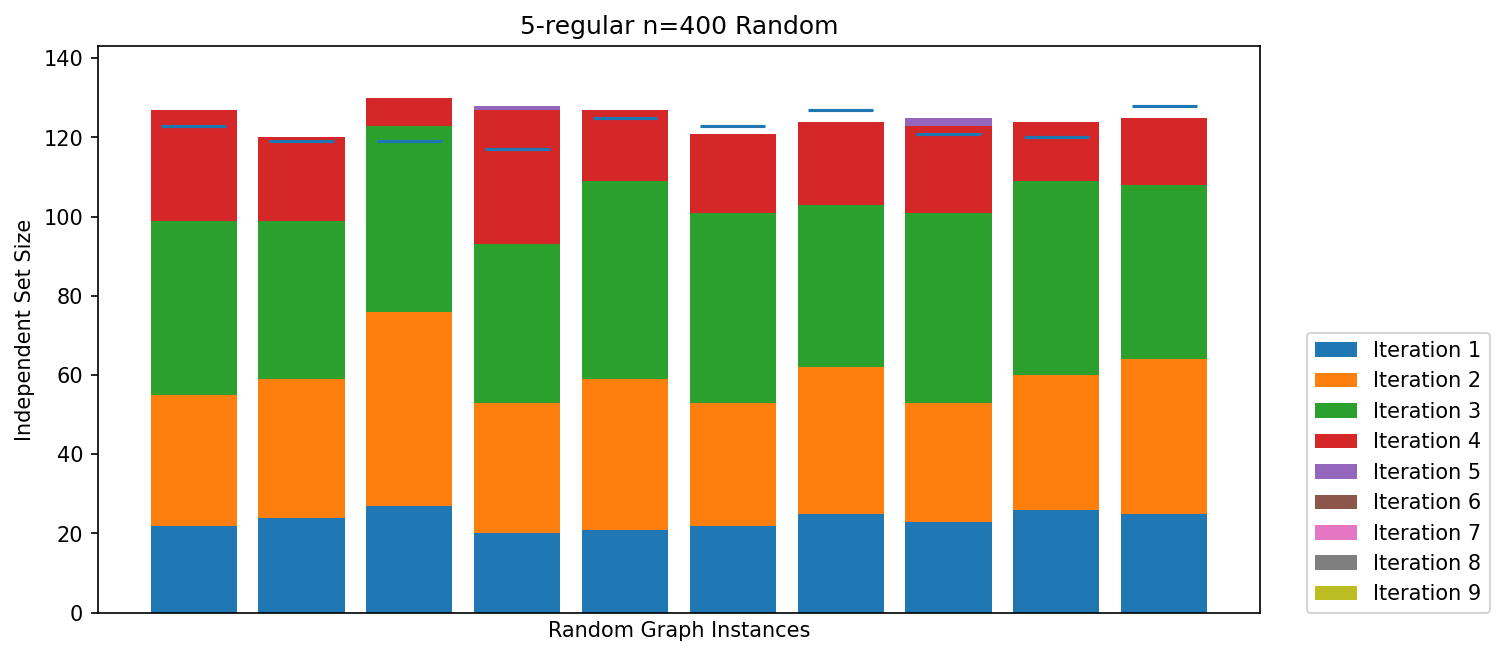

In [23]:
bh_list, progress_list = [], []
NUM_GRAPHS = 10
n = 400
d = 5

for _ in range(NUM_GRAPHS):
    G = nx.random_regular_graph(d, n)
    bh_list.append(len(approximation.maximum_independent_set(G)))
    progress_list.append(classical_MIS_approach(G))
    
    
plt.figure(dpi=150, figsize=(10, 5))
plt.title(f"{d}-regular n={n} Random"); plt.xlabel("Random Graph Instances"); plt.ylabel("Independent Set Size")
plt.ylim(
    0,
    max([max([max(progress) for progress in progress_list]), max(bh_list)]) * 1.1
)
plt.xticks([])

    
for j in range(1, MAX_RECURSION_DEPTH):
    plt.bar(
        range(NUM_GRAPHS),
        [progress[j] - progress[j - 1] for progress in progress_list],
        bottom=[progress[j - 1] for progress in progress_list],
        label=f"Iteration {j}",
    )
    
for i in range(NUM_GRAPHS):
    plt.hlines(bh_list[i], xmin=i-0.3, xmax=i+0.3)
    
plt.legend(loc=(1.04,0));

print("Average BH is", np.mean(bh_list))
print("Average with our classical approach is", np.mean([progress[-1] for progress in progress_list]))

Average BH is 75.6
Average with our classical approach is 76.2


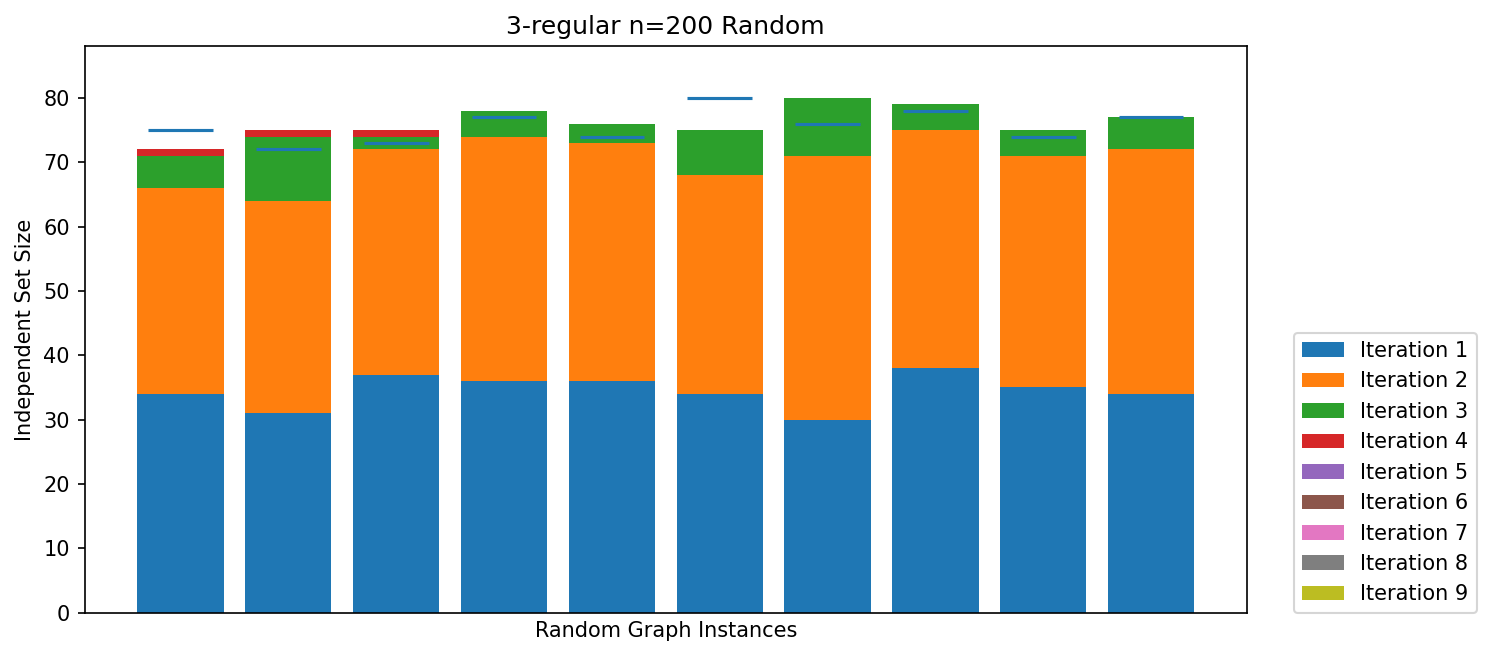

In [24]:
bh_list, progress_list = [], []
NUM_GRAPHS = 10
n = 200
d = 3

for _ in range(NUM_GRAPHS):
    G = nx.random_regular_graph(d, n)
    bh_list.append(len(approximation.maximum_independent_set(G)))
    progress_list.append(classical_MIS_approach(G))
    
    
plt.figure(dpi=150, figsize=(10, 5))
plt.title(f"{d}-regular n={n} Random"); plt.xlabel("Random Graph Instances"); plt.ylabel("Independent Set Size")
plt.ylim(
    0,
    max([max([max(progress) for progress in progress_list]), max(bh_list)]) * 1.1
)
plt.xticks([])

    
for j in range(1, MAX_RECURSION_DEPTH):
    plt.bar(
        range(NUM_GRAPHS),
        [progress[j] - progress[j - 1] for progress in progress_list],
        bottom=[progress[j - 1] for progress in progress_list],
        label=f"Iteration {j}",
    )
    
for i in range(NUM_GRAPHS):
    plt.hlines(bh_list[i], xmin=i-0.3, xmax=i+0.3)
    
plt.legend(loc=(1.04,0));

print("Average BH is", np.mean(bh_list))
print("Average with our classical approach is", np.mean([progress[-1] for progress in progress_list]))

Average BH is 152.1
Average with our classical approach is 152.4


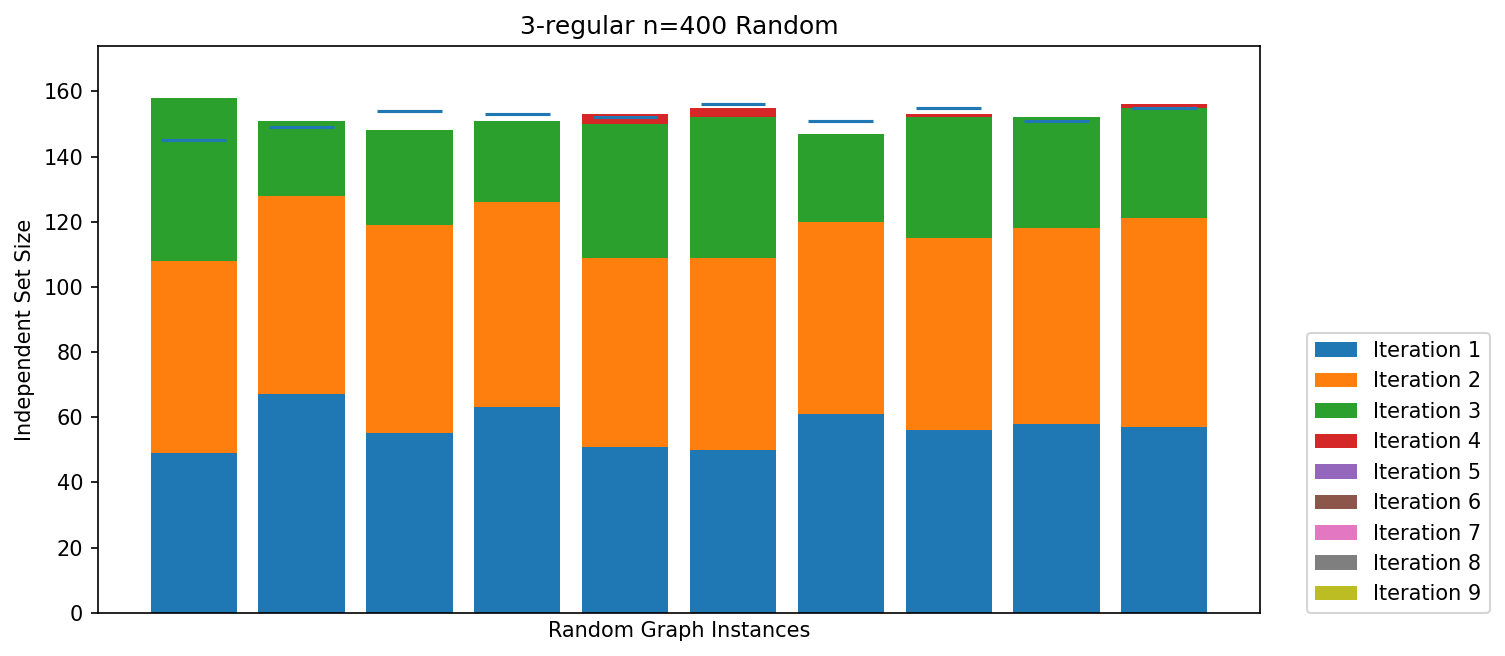

In [25]:
bh_list, progress_list = [], []
NUM_GRAPHS = 10
n = 400
d = 3

for _ in range(NUM_GRAPHS):
    G = nx.random_regular_graph(d, n)
    bh_list.append(len(approximation.maximum_independent_set(G)))
    progress_list.append(classical_MIS_approach(G))
    
    
plt.figure(dpi=150, figsize=(10, 5))
plt.title(f"{d}-regular n={n} Random"); plt.xlabel("Random Graph Instances"); plt.ylabel("Independent Set Size")
plt.ylim(
    0,
    max([max([max(progress) for progress in progress_list]), max(bh_list)]) * 1.1
)
plt.xticks([])

    
for j in range(1, MAX_RECURSION_DEPTH):
    plt.bar(
        range(NUM_GRAPHS),
        [progress[j] - progress[j - 1] for progress in progress_list],
        bottom=[progress[j - 1] for progress in progress_list],
        label=f"Iteration {j}",
    )
    
for i in range(NUM_GRAPHS):
    plt.hlines(bh_list[i], xmin=i-0.3, xmax=i+0.3)
    
plt.legend(loc=(1.04,0));

print("Average BH is", np.mean(bh_list))
print("Average with our classical approach is", np.mean([progress[-1] for progress in progress_list]))

# Collect Classical Data
Run the classical divide and conquer algorithm and the boppana-halldorsson algorithm on the benchmark graphs

In [1]:
from utils.graph_funcs import graph_from_file
import glob
from pathlib import Path

In [5]:
graph_label = 'N26_com2_pin20_pout2_graphs'
graphs = glob.glob(f'benchmark_graphs/{graph_label}/*')
for graphfn in graphs:
    print('/'.join(graphfn.split('/')[1:]))
    graphname = graphfn.split('/')[-1].strip('.txt')
    G = graph_from_file(graphfn)
    for rep in range(1,6):
        print('\tREP', rep)
        bh_mis = len(approximation.maximum_independent_set(G))
        bh_dir = f'benchmark_results/boppana-halldorsson/{graph_label}/{graphname}/'
        Path(bh_dir).mkdir(parents=True, exist_ok=True)
        with open(f'benchmark_results/boppana-halldorsson/{graph_label}/{graphname}/'
                  f'bh_{graphname}_rep{rep}.txt', 'w') as fn:
            fn.write(graphfn + '\n')
            fn.write('Found MIS of size: {}'.format(bh_mis))
        
        dc_mis = classical_MIS_approach(G)
        dc_dir = f'benchmark_results/classical_divide_and_conquer/{graph_label}/{graphname}/'
        Path(dc_dir).mkdir(parents=True, exist_ok=True)
        with open(f'benchmark_results/classical_divide_and_conquer/{graph_label}/{graphname}/'
                  f'dc_{graphname}_rep{rep}.txt', 'w') as fn:
            fn.write(graphfn + '\n')
            fn.write('Found MIS of size: {}'.format(dc_mis))

N26_com2_pin20_pout2_graphs/G2.txt
	REP 1
	REP 2
	REP 3
	REP 4
	REP 5
N26_com2_pin20_pout2_graphs/G3.txt
	REP 1
	REP 2
	REP 3
	REP 4
	REP 5
N26_com2_pin20_pout2_graphs/G1.txt
	REP 1
	REP 2
	REP 3
	REP 4
	REP 5
N26_com2_pin20_pout2_graphs/G4.txt
	REP 1
	REP 2
	REP 3
	REP 4
	REP 5
N26_com2_pin20_pout2_graphs/G5.txt
	REP 1
	REP 2
	REP 3
	REP 4
	REP 5
N26_com2_pin20_pout2_graphs/G7.txt
	REP 1
	REP 2
	REP 3
	REP 4
	REP 5
N26_com2_pin20_pout2_graphs/G6.txt
	REP 1
	REP 2
	REP 3
	REP 4
	REP 5
N26_com2_pin20_pout2_graphs/G10.txt
	REP 1
	REP 2
	REP 3
	REP 4
	REP 5
N26_com2_pin20_pout2_graphs/G8.txt
	REP 1
	REP 2
	REP 3
	REP 4
	REP 5
N26_com2_pin20_pout2_graphs/G9.txt
	REP 1
	REP 2
	REP 3
	REP 4
	REP 5
